In [1]:
# Imports
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import u_us, u_ms, u_V
from PySpice.Unit import *


In [2]:
import schemdraw
import schemdraw.elements as elm

In [29]:
elm.style(elm.STYLE_IEEE)
schemdraw.Drawing(font='Lato')
themes = ['solarizedd', 'solarizedl', 'onedork', 'oceans16', 'monokai', 'gruvboxl', 'gruvboxd', 'grade3', 'chesterish']
schemdraw.theme(themes[6])

In [44]:
NUM_COLS = 10
NUM_ROWS = 10

Point(0,0)
Point(7.325,3.166666666666667)
Point(7.325,5.166666666666667)
Point(7.325,7.166666666666666)


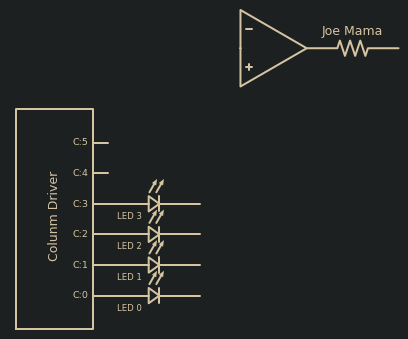

In [69]:
row_driver = elm.Ic(pins=[elm.IcPin(name=f'C:{i}', side='right', anchorname=f'c_{i}') for i in range(NUM_ROWS)],
                    edgepadW = .5,  # Make it a bit wider
                    pinspacing=1).label('Colunm Driver', rotate=90)
with schemdraw.Drawing() as d:
    d += row_driver
    for i in range(4):
        curr_column_driver_pin = getattr(row_driver, f'c_{i}')
        next_column_driver_pin = getattr(row_driver, f'c_{i+1}')
        d += elm.LED() \
                .label(f'LED {i}', loc='bottom', ofst=(-0.8, 0), fontsize=10) \
                .right() \
                .at(curr_column_driver_pin) \
                .drop(next_column_driver_pin)
    d += (opamp := elm.Opamp())
    d += elm.Resistor().right().at(opamp.out).label('Joe Mama')

In [4]:
# Define the circuit
circuit = Circuit('Diode Circuit')

In [5]:

# Add the voltage source
circuit.V('input', '+', circuit.gnd, 1@u_V)

# Add the diode
circuit.X('D1', 'D', 'input', circuit.gnd)

SubCircuitElement XD1

In [6]:
print(circuit)


.title Diode Circuit
Vinput + 0 1V
XD1 input 0 D



In [7]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.initial_condition(input=u_V(0))


2023-04-11 04:33:17,049 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - spinit was not found
2023-04-11 04:33:17,049 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - Note: can't find init file.
2023-04-11 04:33:17,053 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._init_ngspice - WARNING - Unsupported Ngspice version 36


In [8]:
circuit.draw()

AttributeError: draw